In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize




Populating the interactive namespace from numpy and matplotlib


In [3]:
%autoreload

# Parameters used for generating map

In [81]:
nside = 128
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 5)*1.e9

# Generate model using input parameters for comparison

In [82]:
start=time.time()
model_true = ff.model(freqs, A, alpha, beta, gamma)
print(time.time()-start)

1.219283103942871


# Define some data

In [293]:
PS_data_1d = ff.PS_data(30e9, A, alpha, beta, gamma)[2:]

# 1D attempt to fit using `curve_fit`
attempting to fit at 30 GHz for just $A, \alpha$

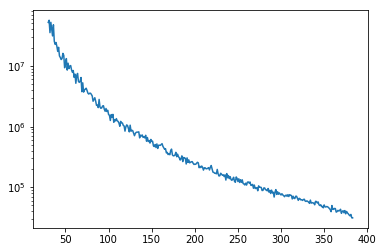

In [85]:
semilogy(ells,PS_data_1d)

In [294]:
%autoreload

In [301]:
start=time.time()
opt_params, covariance = curve_fit(ff.model_single, ells, PS_data_1d, p0=[1e3, -4], 
                                   bounds=(-np.inf,[np.inf,np.inf]), method='trf')
print(time.time()-start)

35.60939693450928


In [232]:
#define a set of initialisation points to step through and print out the best fit parameters extracted from them
As = np.linspace(1, 4, 2)*1e9
alphas = np.linspace(-4,-1,2)

In [234]:
start=time.time()
for i in range(len(As)):
    for j in range(len(alphas)):
        opt_params, covariance = curve_fit(ff.model_single, ells, PS_data_1d, p0=[As[i], alphas[j]], 
                                   bounds=(-np.inf,[np.inf,np.inf]), method='trf')
        
        print('Seed ({:.2e},{:.2f}) produces ({:.2e},{:.2f})'.format(As[i], alphas[j], opt_params[0], opt_params[1]))
        
print(time.time()-start)

Seed (1.00e+09,-4.00) produces (2.45e+09,-0.91)
Seed (1.00e+09,-1.00) produces (1.25e+09,-0.33)
Seed (4.00e+09,-4.00) produces (4.21e+09,-0.67)
Seed (4.00e+09,-1.00) produces (8.19e+09,0.13)
158.46907591819763


In [302]:
print(opt_params)

print(np.sqrt(np.diag(covariance)))

[1966.17749728   -2.82779916]
[0.60415589 0.00333141]


In [250]:
opt_params

array([703.12549587,  -1.49584047])

In [251]:
print(A, alpha, gamma)

1700.0 -3.0 -2.5


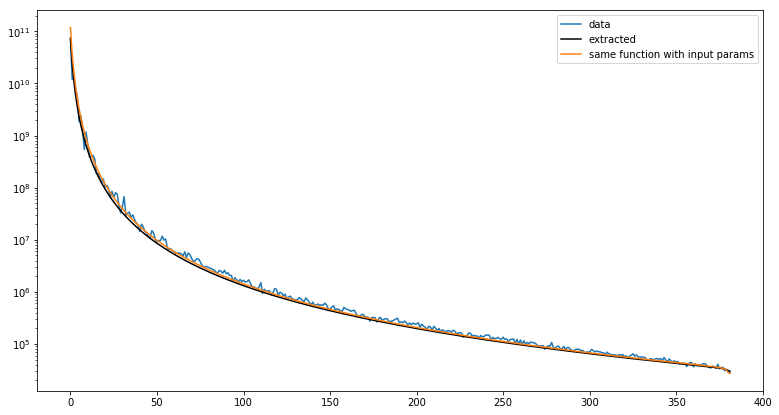

In [303]:
#over plot the curve that has been extracted
figure(figsize=(13,7))
semilogy(PS_data_1d, label='data')
semilogy(ff.model_single(ells, opt_params[0], opt_params[1]), 'k',label='extracted');
semilogy(ff.model_single(ells, A, alpha), label='same function with input params')
legend();

# there is some effect to cutting out the low ell, but not too much. For the moment just cut [2:]

In [187]:
#okay, so this worked up until adding the 0x2 term... Interesting, that's not the one I would have guessed
#would break it...
#can do curve_fit pretty well with 0x0+1x1 term, but not with 0x0+1x1+0x2...

#so with the 0x2 term added to ff.model_single the minimizer doesn't move from starting position much...

In [185]:
#so this appears to be working until either
# - 0x2 term is included (even if we're just fitting A and alpha this breaks it)
# - gamma is included as a parameter (even if we don't include the 0x2 term)

# Adding in gamma as a prameter
running 0x0+1x1 and fitting $A, \alpha, \gamma$ (as the 0x2 breaks it)

In [254]:
%autoreload

In [290]:
start=time.time()
opt_params, covariance = curve_fit(ff.model_single, ells, PS_data_1d, p0=[1e3, -1, -3], 
                                   bounds=(-np.inf,[np.inf,np.inf,-2.01]), method='trf')
print(time.time()-start)

24.507060050964355


In [282]:
#all of the below opt_params are from the same initial point and with the same dataset, they vary
#quite a lot in where they settle in this space... and most of the time they don't settle well

In [291]:
opt_params

array([1187.49741224,   -2.61621563,   -3.0000119 ])

In [265]:
opt_params

array([2187.73417616,   -2.50880966,   -3.11815735])

In [263]:
opt_params

array([750.0384125 ,  -2.17673043,  -3.5439006 ])

In [261]:
opt_params

array([812.49915827,  -1.24347748,  -3.00102684])

In [259]:
opt_params

array([750.95984506,  -3.1426459 ,  -3.50740753])

In [256]:
opt_params

array([978.33122466,  -3.06303811,  -2.13919133])

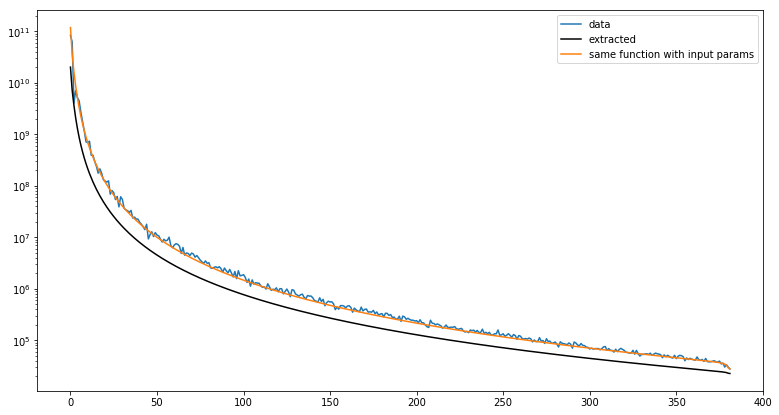

In [292]:
#over plot the curve that has been extracted
figure(figsize=(13,7))
semilogy( PS_data_1d, label='data')
semilogy( ff.model_single(ells, opt_params[0], opt_params[1], opt_params[2]), 'k',label='extracted');
semilogy( ff.model_single(ells, A, alpha, gamma), label='same function with input params')
legend();